# Atividade 3 - Segmentação Semântica

### A) Densenvolva uma rede neural para segmentação semântica que seja capaz de segmentar algumas classes de interesse na cena apresentada como entrada do modelo. Para isso, crie um modelo similar à arquitetura da Rede U-net ou o da própria U-net se for de seu interesse, a fim de resolver o problema.
### B) O dataset utilizado para esta atividade será o CITYSCAPE DATASET: [link-cityscape](https://www.kaggle.com/dansbecker/cityscapes-image-pairs/download) (cique neste link para baixar no diretório principal de seu projeto)
### OBS1: Este dataset contém frames rotulados (segmentados) capturados a partir de veículos nas ruas da Alemanha.
### OBS2: Os comandos da atividade seguem com intruções a partir dos intens enumerados a seguir.

#### 1 - Seguem algumas bibliotecas que podem ser necessárias:

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10544285781394152718
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11816852617793051605
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14217549788284389814
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random
from joblib import dump, load

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

#### 2 - Após ter baixado o dataset apresentado no item B) no mesmo diretório deste jupyter notebook, extraia o 'archive.zip' e abaixo temos os path's para as imagens de treino e validação.

In [3]:
train_path='cityscapes_data/train'
val_path='cityscapes_data/val'

#### 3 - As imagens do dataset vieram da seguinte forma:

![](./imagens/exemplo_dado.jpg)

#### OBS: Ou seja, apresenta a imagem de entrada concatenada com a versão da imagem esperada (segmentada)!

#### 4 - [Implemente]: Complete a função seguinte (_load_image_pair_), de modo que ela seja capaz de ler a imagem como um numpy array no formato RGB, seja usando opencv ou Pillow e que retorne separadas as imagens de entrada e segmentada.

In [4]:
 def load_image_pair(file_name,
                    path=train_path,
                    rotation=0.0,
                    flip=False,
                    size=(256, 256)):
    
    # Path da imagem do dataset de treino ou validação. 
    # Por default o parâmetro está pegando o path de treino.
    image_path = os.path.join(path, file_name)
    
    # Neste bloco leia a Imagem neste bloco como RGB numpy array.
    imgs_concat = cv2.imread(image_path)
    imgs_concat = cv2.cvtColor(imgs_concat, cv2.COLOR_BGR2RGB)
    
    # Neste bloco separe imagem de entrada e imagem segmentada.
    seg = imgs_concat[:,256:]
    img = imgs_concat[:,:256]
    
    #Este boco irar equalizar os canais RGB da imagem - Já implementado
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
        
    list_images = [img, seg]
    
#     bins = np.linspace(0, 255, 10)
#     digitized = np.digitize(seg.ravel(), bins)
#     digitized = digitized - 1
#     seg = bins[digitized].reshape(seg.shape).astype(np.uint8)
    
    # Neste bloco dê um resize nas duas imagens para o size passado como paâmetro na função.
    # Esse será o tamanho da entrada da nossa rede neural.
#     for i in range(len(list_images)):
#         list_images[i] = cv2.resize(list_images[i], size, interpolation=cv2.INTER_CUBIC)
    
    # Neste bloco aplique uma rotação na imagem (isso será usado mais a frente emum generator).
    # Por default este parâmetro está com rotação de 0 graus, ou seja, não vai rotacionar a princípio.
    if rotation != 0.0:
        for i in range(len(list_images)):
            image_center = tuple(np.array(list_images[i].shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, rotation, 1.0)
            list_images[i] = cv2.warpAffine(list_images[i], rot_mat, list_images[i].shape[1::-1], flags=cv2.INTER_CUBIC)
   
    # Neste bloco as duas imagens sofrem um flip horizontal. Por default está False. Ou seja, não vai flippar,
    # a menos que peçamos para tal. Servirar par ao genrator mais a frente.
    if flip:
        for i in range(len(list_images)):
            list_images[i] = list_images[i][:,::-1,:]
    
    return list_images[0]/255, list_images[1]/255 # Ao final já normaliza as duas imagens entre 0 e 1!

In [5]:
img, seg = load_image_pair("2.jpg")

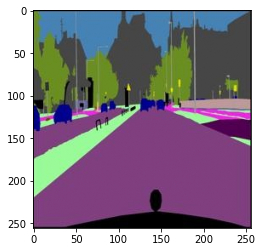

In [6]:
plt.imshow(seg)

#### 5 - [Implemente]: Agora vamos treinar o KMEANS para separar as cores das imagens segmentadas com K=13 categorias. Isso servirá para gerar o mapa de labels dos pixels.

##### 5.1 - Vetorize as imagens RGB versão segmentada do conjunto de treinamento e armazene todas em uma lista _colors_: Por exempo, se as imagens estão com o shape (256, 200, 3) devem se tornar com o shape (256*200, 3) - [ou seja, os três canais RGB devem ficar intactos]:
##### OBS: Use a função load_image_pair para carregar as imagens com os parâmetros de data augmentation default.

In [7]:
colors = []

for file in os.listdir(train_path):
    _, seg = load_image_pair(file)
    colors.append(np.reshape(seg, (-1, 3)))

In [8]:
test_colors = np.reshape(colors[0], (256, 256, 3))

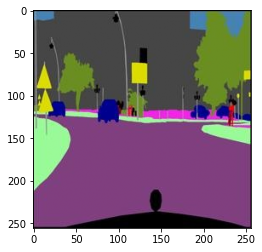

In [9]:
plt.imshow(test_colors)

##### 5.2 - Vamos transformar a lista de arrays RGB em um grande array usando a função np.array():

In [10]:
colors_array = np.array(colors[:550]) # Só 10 imagens da base train - são 2975 no total

In [11]:
colors_array.shape

(550, 65536, 3)

##### 5.3 - Vamos transformar o ARRAY  de todas as imagens RGB de treino em uma grande matriz de pixels RGB: Por exemplo. Aqui o array será algo com o shape (número de  imagens, 256 * 200, 3), vamos dar um reshape e torná-la (número de  imagens * 256 * 200, 3) e Aplicar o Kmeas de K=13 nela para seguimentar as tuplas RGB.

In [12]:
rgb_arr = np.reshape(colors_array, (-1, 3))

In [13]:
rgb_arr.shape

(36044800, 3)

In [14]:
K = n_colors = 13

km = KMeans(K).fit(rgb_arr)

In [15]:
dump(km, 'km.joblib')

['km.joblib']

In [16]:
km_pkl = load('km.joblib')

In [17]:
test_k = np.reshape(km_pkl.labels_, (550, -1)) # Só 10 imagens da base train - são 2975 no total

####  6 - [Implemente]: Implementar a função que irá receber a imagem versão segmentada e gerar a partir dela o tensor (conjunto de mapas de features -  como o da figura abaixo) usando o Kmeans que foi treinado para rotular os pixels de cada categoria:

<img src="./imagens/19.png" alt="drawing" width="800"/>

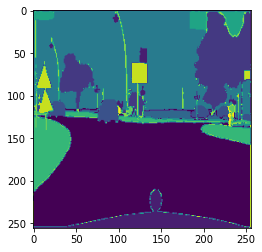

In [18]:
seg_k = np.reshape(test_k[0], (256, -1))
plt.imshow(seg_k)

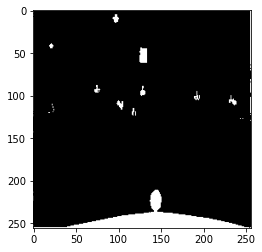

In [24]:
plt.imshow(np.where(seg_k == 1, 1, 0), cmap='gray')

In [20]:
def colors_to_class_layers(seg):
    
    # Deixa imagem no formato necessário para passar no Kmeans -- já codificado
    s = seg.reshape((-1, 3))
    
    # Passa no Kmenas treinado -- já codificado
    s = km.predict(s)
    
    # Pega a imagem gerada pelo agrupamento do Kmeans no format linhas x colunas  --- já codificado
    s = s.reshape((seg.shape[:2]))
    
    # Pega número de clusters e cria um array-tensor com o número de mapas com a quantidade de 
    # classes (clusters) -- já codificado
    classes = np.zeros((seg.shape[0], seg.shape[1], n_colors))
    
    # Neste bloco, implemente um for sobre as classes (clusters), crie uma cópia de s e verifique 
    # quais pixels dele tem valor igual ao índice que representa a classe da vez. Quando for igual 
    # atribua o valor 1 a exste pixel e quando não atribua zero. Assim teremso mapas para as classes 
    # sendo imagens binárias (com zeros e uns). Depoois preencha os n mapas no array classes e retorne ele.
    
    for i in range(n_colors):
        this_color = np.where(seg_k == i, 1, 0)
        classes[:,:,i] = this_color
       
    return classes

In [28]:
g = colors_to_class_layers(test_colors)

In [30]:
g.shape

(256, 256, 13)

In [ ]:
plt.imshow(g)

#### 7 - Abaixo, segue já implementada uma função para converter a imagem segmentada no formato de layers para uma imagem RGB para ser apresentada.

In [21]:
def layers_to_rgb_image(layers):
    
    # Lista de tuplas RGB para representar as cores das regiões segmentadas. 
    # 13 cores e mais o preto para quando não for nenhuma das classes de interesse
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0), (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    # Imagem de saída.
    img_out = np.zeros((layers.shape[0], layers.shape[1], 3))
    
    for i in range(layers.shape[2]): # Percorre as n layers, no caso aqui 13 classes
        
        c = layers[:,:,i] # Pega a layer da vez
        col = colors[i] # Pega uma cor pra essa layer/classe
        
        for j in range(3): # percorre os canais RGB
            img_out[:,:,j] += col[j]*c # Pega a layer binária e multiplica pela cor que ela deverá ter
            
    img_out = img_out/255.0 # Normaliza imagem resultante entre 0 e 1 e, em seguida retorna
    
    return img_out

#### 8 - [Implemente]: Abaixo, segue um generator que será usado para o treinamento. Por default, já está o path dos dados de treinamento, mas tambem poderá ser usada para os dados de validação também.

In [22]:
def Generate(path=train_path,
             batch_size=32,
             maxangle=10.0):
    
    # Maxangle é o angulo máximo que a imagem pode ser rotacionada. Por default é 10.
    
    image_files = os.listdir(path)
    
    while True:
        
        # Listas para imagem e versão segmentada
        imgs=[]
        segs_layers=[]
        
        for i in range(batch_size):# For para geração do batch/lote
            
            file = random.sample(image_files, 1)[0] # Sorteia um arquivo entre todos.
            
            # Neste bloco, implemente uma forma de aleatoriamente a imagem da vez ser flippada 
            # na Horizontal ou não, bem como sortear um angulo para rotacionar entre -maxangle e maxangle
            # que, por default, é 10 e pode manter esse angulo máximo para a atividade.
            
            angle = random.uniform(-maxangle, maxangle)
            flip = random.choice([True, False])
            
            # Usa a função load_image_pair implementada lá em cima
            # recebe o arquivo da vez, o path de treinamento ou validação, o angulo
            # para rotacionar e a flag flip para flippar na horizontal ou não.
            img, seg = load_image_pair(file, path, rotation=angle, flip=flip)
            
            # Retora o mapa de layers da imagem segmentada
            seg_layers = colors_to_class_layers(seg)
            
            imgs.append(img)
            segs_layers.append(seg_layers)
            
            
        # Retorna (yield) imagens com augmentation ou não, bem como sua versão segmentada no formato de layers
        yield np.array(imgs), np.array(segs_layers) 

#### 9 - [Implemente]: Crie aqui o modelo U-net ou inspirado na arquitetura dele! A parte condificadora já está pré-codificada e o início da parte Decodificadora também está. Complete.

In [31]:
input_layer = Input(shape=(256, 256, 3))

x1 = BatchNormalization()(input_layer)
x1 = Conv2D(13, 12, activation="relu", padding="same")(x1)
x1 = Conv2D(128, 12, activation="relu", padding="same")(x1)
p1 = MaxPooling2D()(x1)


x2 = Conv2D(128, 9, activation="relu", padding="same")(p1)
x2 = Conv2D(128, 9, activation="relu", padding="same")(x2)
p2 = MaxPooling2D()(x2)


x3 = Conv2D(128, 6, activation="relu", padding="same")(p2)
x3 = Conv2D(128, 6, activation="relu", padding="same")(x3)
p3 = MaxPooling2D()(x3)


x4 = Conv2D(128, 3, activation="relu", padding="same")(p3)
x4 = Conv2D(128, 3, activation="relu", padding="same")(x4)


x5 = UpSampling2D()(x4)
x5 = concatenate([x3, x5])
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)
x5 = Conv2D(128, 6, activation="relu", padding="same")(x5)


x6 = UpSampling2D()(x5)
x6 = concatenate([x2, x6])
x6 = Conv2D(128, 9, activation="relu", padding="same")(x6)
x6 = Conv2D(128, 9, activation="relu", padding="same")(x6)

x7 = UpSampling2D()(x6)
x7 = concatenate([x1, x7])
x7 = Conv2D(128, 12, activation="relu", padding="same")(x7)
x7 = Conv2D(13, 12, activation="softmax", padding="same")(x7)


model = Model(input_layer, x7)

optmizer = Adam(lr=0.0001)
model.compile(optimizer=optmizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [32]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 13) 5629        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 128 239744      conv2d_14[0][0]                  
_______________________________________________________________________________________

#### 10 - [Implemente]: Instancie os generator de treino e validação (já está ocdificado) e treine o modelo usando o fit_generator do keras:
#### OBS: Use o callback que está abaixo no treinamento.
#### DICA: vai precisar de pelo menos umas 100 épocas para ter um resultado razoável. Usem o COLAB!

In [33]:
train_gen = Generate(train_path)
val_gen = Generate(val_path)

In [34]:
callback_list = [ModelCheckpoint("model_best.h5", save_best_only=True, verbose=0)]

In [ ]:
history = model.fit(train_gen,
                    epochs=10,
                    steps_per_epoch=5,
                    validation_data=val_gen,
                    validation_steps=5,
                    callbacks=callback_list)

Epoch 1/10
5/5 [==============================] - 6237s 1247s/step - loss: 2.1768 - accuracy: 0.3144 - val_loss: 2.0305 - val_accuracy: 0.4055
Epoch 2/10
5/5 [==============================] - 6805s 1361s/step - loss: 1.8459 - accuracy: 0.3807 - val_loss: 1.7383 - val_accuracy: 0.4606
Epoch 3/10
5/5 [==============================] - 3820s 764s/step - loss: 1.7626 - accuracy: 0.4265 - val_loss: 1.8343 - val_accuracy: 0.4956
Epoch 4/10
5/5 [==============================] - 5718s 1144s/step - loss: 1.6996 - accuracy: 0.4785 - val_loss: 1.7021 - val_accuracy: 0.4631
Epoch 5/10
5/5 [==============================] - 4508s 902s/step - loss: 1.7057 - accuracy: 0.4832 - val_loss: 2.1051 - val_accuracy: 0.3293
Epoch 6/10
5/5 [==============================] - 3925s 785s/step - loss: 1.8935 - accuracy: 0.3980 - val_loss: 1.9289 - val_accuracy: 0.3969
Epoch 7/10


#### 11 - [Implemente]: Plote as curvas de treinamento loss e accuracy de treino e validação:

#### 12 - [Implemente]: Plote para pelo menos 20 imagens do conjunto de validação após passar no modelo treinado sua versào segmentada esperada (label) e a imagem obtida! Use as funções implementadas lá em cima que forem necessárias para as conversões.
#### OBS: Algo parecido com a imagem abaixo.

![](./imagens/example-out.png)

#### %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [ ]:
test_gen = Generate(val_path)

for imgs, segs in test_gen:
    
    # ??????
    # ??????
    # ??????
    # ??????

### FIM